# 1. Problématiques de Business 

Notre client c'est une jeune start'up spécialisée dans l'alimentation végan souhaite développer son nouveau concept sur le territoire Français: des ateliers de cuisine vegan. 

Potantiel problématiques à répondre sont suivantes :

- Quel intérêt porte les Français à la cuisine Végan
- Quels sont les plats tendances
- Quels sont les sites géographiques dans lesquels il serait le plus intéressant de s'implanter

# 2. Data Acquisition

- Pour les datasets, j'ai principalement utilisé le site web "Google Trend", 

- D'abord en emplayant different combinason de mot "vegan", j'ai récuperé 5 differentes datasets et les ai combiné pour voire l'intérét des Français sur le théme Végan

- Fichier geojson qui définit les zones / frontières de la France https://france-geojson.gregoiredavid.fr/

- Pour les latitudes et longtitudes des Departements "https://www.gps-longitude-latitude.net/coordonnees-gps-de-haute-garonne"

- J'ai récuperé des données par rapport aux plats préférés des français des differentes sites web.

- Dernierement, j'ai récuperé l’évolution temporelle de l’intérêt pour la nourriture végan par par ville et la population des villes sur le site web "https://www.insee.fr/fr/statistiques/4277596?sommaire=4318291".

## Import Librairies

In [1]:
import numpy as np # to handle data in a vectorized manner
import pandas as pd # for data analsysis
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium # map rendering

import glob

pd.set_option("display.max_columns", None) # to be able to see all columns
pd.set_option("display.max_rows", None) # to be able to see all rows


## les sites géographiques dans lesquels il serait plus intéressant de s'implanter


In [2]:
# Population par Departement

df_dep = pd.read_excel('dataset_k/dep.xlsx') #pd.read_html('https://www.insee.fr/fr/statistiques/4277596?sommaire=4318291')[1]
df_dep.columns = ['Departement', 'Population','variation']
del df_dep['variation']
df_dep['Departement'] = df_dep['Departement'].str.replace('\d+', '').str.replace(' ', '')
df_dep['Population'] = df_dep['Population']*1000
df_dep.head()

,Departement,Population
0,Ain,656955.0
1,Aisne,526050.0
2,Allier,331315.0
3,Alpes-de-Hte-Pce,165197.0
4,Hautes-Alpes,141756.0


In [3]:
# L'interet des gens au sujet vegan par Departement

df_dep_veg = pd.read_csv('dataset_k/3.depertement.csv', skiprows=1)
df_dep_veg.columns = ['Departement','Vegan']
df_dep_veg.head()

,Departement,Vegan
0,Paris,100
1,Val-de-Marne,92
2,Bas-Rhin,91
3,Alpes-Maritimes,89
4,Haute-Garonne,87


In [4]:
# Merge deux datasets
df_departement = pd.merge(df_dep_veg,df_dep, how='left', on='Departement')

# Aprés merge, Remplir les données manquant en main
df_departement['Population'][25, 39, 48, 58] = 165197.0, 162421.0, 182258.0, 140145.0
df_departement['Population'] = df_departement['Population'].astype(int)
df_departement.head()

,Departement,Vegan,Population
0,Paris,100,2148271
1,Val-de-Marne,92,1406041
2,Bas-Rhin,91,1132607
3,Alpes-Maritimes,89,1079396
4,Haute-Garonne,87,1400935


In [5]:
# les zones / frontières de la France
france_geo_dep = r'dataset_k/departements.geojson.txt'


threshold_scale = np.linspace(df_departement['Vegan'].min(),
                              df_departement['Vegan'].max(),
                              10, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum order number



In [6]:
# Les 5 departement qui ont les plus d'intéret au sujets vegan 
df_coordination = df_departement.head(5)
# Les information de geolocalization
df_coordination['Lat'] = ['48.8534', '48.7931426', '48.6343172', '43.9466791', '43.4010462']
df_coordination['Long'] = ['2.3488', '2.4740337', '7.5252938', '7.179026', '1.135302']
df_coordination['Population'] = df_coordination['Population'].apply(lambda x : "{:,}".format(x))

df_coordination.head() 

,Departement,Vegan,Population,Lat,Long
0,Paris,100,"2,148,271",48.8534,2.3488
1,Val-de-Marne,92,"1,406,041",48.7931426,2.4740337
2,Bas-Rhin,91,"1,132,607",48.6343172,7.5252938
3,Alpes-Maritimes,89,"1,079,396",43.9466791,7.179026
4,Haute-Garonne,87,"1,400,935",43.4010462,1.135302


In [7]:
# create a plain world map
map_france = folium.Map(location=[45.764043, 4.835659], zoom_start=5)
# generate choropleth map 
map_france.choropleth(
    geo_data= france_geo_dep,
    data = df_departement,
    columns=['Departement','Vegan'],
    key_on = 'properties.nom', #'feature.id',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Vegan Status par Departement' )


population = folium.map.FeatureGroup()

for lat, lng, in zip(df_coordination.Lat, df_coordination.Long):
    population.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(df_coordination.Lat)
longitudes = list(df_coordination.Long)
labels = zip(list(df_coordination.Departement), list(df_coordination.Population), list(df_coordination.Vegan)) #+ df_coordination.Departement

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_france)

map_france.add_child(population)

## l’intérêt des français sur le thème Véga

In [11]:
from functools import reduce

files = glob.glob('dataset_k/1.*')

liste_dfs=[]

for nom_file in files :
    df = pd.read_csv(nom_file,skiprows=1) #index_col=None, header=0
    liste_dfs.append(df)

df_vegan_temps = reduce(lambda x, y: pd.merge(x, y, on = 'Semaine'), liste_dfs)

df_vegan_temps['Vegan'] = (df_vegan_temps.iloc[:,1]+df_vegan_temps.iloc[:,2]+df_vegan_temps.iloc[:,3]+df_vegan_temps.iloc[:,4]+df_vegan_temps.iloc[:,5])/5

df_vegan_temps.drop(df_vegan_temps.columns[[1,2,3,4,5]],axis=1,inplace=True)
df_vegan_temps.head(5)



,Semaine,Vegan
0,2015-12-13,45.4
1,2015-12-20,47.4
2,2015-12-27,50.8
3,2016-01-03,46.6
4,2016-01-10,38.8


In [27]:
import plotly.express as px 
fig = px.line(df_vegan_temps, x='Semaine', y = 'Vegan')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=4, label="2017-2020", step="year", stepmode="backward"),
            dict(count=3, label="2018-2020", step="year", stepmode="backward"),
            dict(count=2, label="2019-2020", step="year", stepmode="todate"),
            dict(count=12, label="2020", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

- Aprés 2015 il exist un fort croisant de l'interet aux sujet vegan
- Dernier 5 ans, on peut dire que l'interet est stable
- On remarque que pendant hiver l'interet augment mais pendant l'ete ca shute 

<AxesSubplot:xlabel='year'>

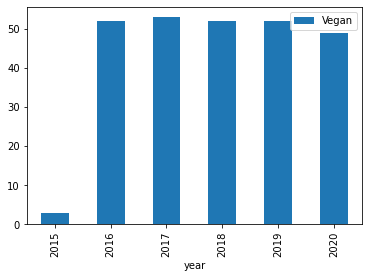

In [47]:
df_vegan_temps['Semaine'] = df_vegan_temps['Semaine'].astype("datetime64")
df_vegan_temps['year'] = df_vegan_temps['Semaine'].dt.year
df_vegan_temps[['Vegan','year']].groupby(by=['year']).count().plot(kind="bar")


## les plats préférés des français 

In [61]:
list_plat = [
'Chili végétarien','Lasagnes végétariennes','Lasagnes aux légumes et feta façon végétarienne',
'Biryani végétarien','Paëlla végétarienne','Lasagnes végétariennes au Thermomix','Chili con carne végétarien','Couscous végétarien','Moussaka végétarienne','Maghmouh libanais ou moussaka végétarienne','Fajitas végétarienne à l’avocat','Tacos végétarien','Sushis végétariens','Bo Bun végétarien','Risotto aux champignons végétarien','Risotto aux tomates végétarien','Pizza végétarienne','Fondue chinoise végétarienne végétarien','Pad thaï végétarien','Tajine végétarien aux pruneaux','Cannelloni végétariens','Burritos végétariens au quinoa épicé','Tagliatelles végétarienne à la bolognaise','Makis végétarien','Dahl de lentilles indien végétarien','Curry végétarien','Calzone végétarienne','Mafé végétarien','Pâtes chinoises végétariennes','Riz cantonais végétarien','Wok végétarien quinoa','Quesadillas végétariennes','Burger végétarien au steak de soja','Burger végétarien aux pois chiches','Burger végétarien aux lentilles','Burger végétarien à la galette de semoule','Hamburger végétarien sauce au yaourth','Hamburger végétarien','Burger végétarien au steak de carottes','Burger végétarien au steak de betterave','Burger végétarien au steak de millet à l’avocat et à l’oignon rouge','Burger végétarien aux courgettes','Burger végétarien au tofu','Burger végétarien à la galette de semoule',
'Burger végétarien au palet de petits pois à l’oeuf','Hamburger végétarien','Burgers végétariens au fromage de chèvre','Burger rose végétarien, betteraves, haricots et oignons rouges',
'Hachis parmentier végétarien','Raclette végétarienne','Courgettes farcies végétariennes','Poivrons farcis végétariens','Potée de légumes végétarienne','Papillotes végétariennes de lentilles au curry et légumes à la feta','Assiette végétarienne','Cassoulet végétarien','Saucisse végétarienne','Boudin blanc végétarien','Poêlée végétarienne','Croque végétarien','Croque-monsieur végétarien avocat, mozzarella et épinards','Blanquette végétarienne au seitan','Potée aux lentilles végétarienne facile','Tartiflette végétarienne','Gratin végétarien','Pot au feu végétarien de poireaux','Raclette végétarienne','Gratin de potimarron végétarien','Choux de bruxelles braisés à la marjolaine végétarien','Vichyssoise végétarien','Bourguignon végétarien au tofu et seitan']

np.random.seed(seed=42)
tendences = np.random.randint(0,100, len(list_plat))

df_plats_tendences = pd.DataFrame(data = {'plat' : list_plat, 'popularite' : tendences})
df_plats_tendences.sort_values(['popularite'], ignore_index=True, inplace=True, ascending=False)
df_plats_tendences = df_plats_tendences.head(10)

images = ['https://d2qr63i3uw2hd1.cloudfront.net/recipe_photos/slide/163696/IMG_4268.jpg',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRnPZtS0YM0uX0m6zqSae9cJjJSoZoiN122Yw&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEIRixU4--yQptqBTSQj9Rny5YVj2U4AT6PQ&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVr6kcLMvroenBxW7k6udy7AhHh63RGl0c2A&usqp=CAU',
         'https://www.lavieclaire.com/wp-content/uploads/2019/04/wok-de-quinoa-choux-et-raisins-2-560x420.jpg',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRpV2BkHVlyiLqZFxzdtLC7cwPTw0XqkBj0uQ&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKHFEP4z5j1_f7sQDytNznNk6Kfdqz2k3B8Q&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRdsjv3OkOZDwo5pnouBi-BRDszvnyiZsZCeg&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFc5ebvpWsem8rH_xQH-dOQzCkahsS_GJ8qw&usqp=CAU',
         'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ7RubgkfpTDS_S5QORM3_Ty6aKgBfacLryTw&usqp=CAU']
 
df_plats_tendences['image'] = images

from IPython.core.display import HTML

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', -1)

HTML(df_plats_tendences.to_html(escape=False ,formatters=dict(image=path_to_image_html)))

,plat,popularite,image
0,Tacos végétarien,99,
1,Lasagnes végétariennes,92,
2,"Croque-monsieur végétarien avocat, mozzarella et épinards",91,
3,Burger végétarien aux pois chiches,91,
4,Wok végétarien quinoa,90,
5,Saucisse végétarienne,89,
6,Potée de légumes végétarienne,88,
7,Pâtes chinoises végétariennes,88,
8,Fondue chinoise végétarienne végétarien,87,
9,Fajitas végétarienne à l’avocat,87,
